# <div style="background-color: #153B50; font-family: Trebuchet MS; color: #FFFFFF; padding: 5px; font-size: 150%; text-align: center; line-height: 1; border-radius: 10px 10px;">Customer Segmentation</div>

---

In this project, unsupervised clustering will be performed on customer log data from the wholesale company database. Customer segmentation is the technique of categorizing consumers based on their common characteristics. Customers will be separated into divisions to maximize the value of each customer to the business. It is done to modify the product based on the wants and behaviors of the customer. It also helps to suit the needs of a wide range of clients.

# <div style="background-color: #153B50; font-family: Trebuchet MS; color: #FFFFFF; padding: 12px; border-radius: 10px 10px;">Import Library Required</div>

In [2]:
!pip install scikit-learn-extra

In [3]:
# importing libraries

import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

# <div style="background-color: #153B50; font-family: Trebuchet MS; color: #FFFFFF; padding: 12px; border-radius: 10px 10px;">Load Dataset</div>

In [4]:
# load dataset

data = pd.read_csv(
    "/kaggle/input/customer-personality-analysis/marketing_campaign.csv",
    sep="\t"
)
print(f"Jumlah record data: {len(data)}")
data.head()

Jumlah record data: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


Informasi detail dataset [disini](https://www.kaggle.com/imakash3011/customer-personality-analysis).

# <div style="background-color: #153B50; font-family: Trebuchet MS; color: #FFFFFF; padding: 12px; border-radius: 10px 10px;">Data Cleaning</div>

**In this section**
* Data Cleaning
* Feature Engineering

To understand the steps to be taken next. The following is the information in the dataset.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

**From the output above, it can be concluded and noted that:**

* There is a missing value in the income column
* The Dt_Customer column shows the date the customer joined the database not parsed into DateTime
* There are several categorical features in the DataFrame; because there are several features with the data type: object. So it needs to be encoded into numerical form later.

First of all, for missing values, simply delete rows of data that have missing values.

In [6]:
# delete data with NA values
data = data.dropna()
print("The total data-points after deleting rows with missing values are:", len(data))

The total data-points after deleting rows with missing values are: 2216


The next step, create a feature from **"Dt_Customer"** that shows the number of days a customer is registered in the company database. However, to maintain simplicity, here we will take the value relative to the most recent customer in the data record.

Therefore, to get these values, you must check the latest and oldest recorded dates.

In [7]:
# get data

data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], format='%d-%m-%Y')

dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)

# tanggal terbaru dan terlama yang tercatat
print("The most recent customer subscription date in the record:", max(dates))
print("The date of the oldest customer subscription in the record:", min(dates))

The most recent customer subscription date in the record: 2014-06-29
The date of the oldest customer subscription in the record: 2012-07-30


Created a **"Customer_For"** feature that shows the number of days since a customer started shopping at the store against the last recorded date.

In [8]:
# create feature "Customer_For"

days = []
# capture value as newest customer
d1 = max(dates)

for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors= "coerce")

Now, try exploring the unique values in the categorical features to get a clear picture of the data.

In [9]:
print("Categorical totals in the Marital_Status feature:\n", data["Marital_Status"].value_counts(), "\n")
print("Categorical totals in the Education feature:\n", data["Education"].value_counts())

Categorical totals in the Marital_Status feature:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Categorical totals in the Education feature:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


**In the next section, take steps to create some new features:**

* Extracts **"Age"** of a customer based on **"Year_Birth"** which indicates the year of birth of the person concerned.
* Create another feature **"Spent"** that shows the total amount spent by customers in various categories over two years.
* Create another feature **"Living_With"** from **"Marital_Status"** to extract a couple's living conditions.
* Create a **"Children"** feature to show the total number of children in a household, i.e., children and teens.
* To get a better idea of the household, create a feature that shows **"Family_Size"**.
* Create a **"Is_Parent"** feature to indicate parent status.
* Finally, create three categories in **"Education"** by simplifying the number of values.
* Remove some redundant features.

In [10]:
# feature engineering

# customer age (today)
data["Age"] = 2024-data["Year_Birth"]

# total spending on several item categories
data["Spent"] = data["MntWines"] + data["MntFruits"] + data["MntMeatProducts"] + data["MntFishProducts"] + data["MntSweetProducts"] + data["MntGoldProds"]

# generate living condition with marital status "Alone"
data["Living_With"] = data["Marital_Status"].replace({"Married": "Partner", "Together": "Partner", "Absurd": "Alone", "Widow": "Alone", "YOLO": "Alone", "Divorced": "Alone", "Single": "Alone",})

# feature that indicates the total number of children living in the same household
data["Children"] = data["Kidhome"] + data["Teenhome"]

# features for total families living in one house
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner": 2}) + data["Children"]

# feature that shows parent status
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

# segmentation for education level into 3 groups
data["Education"] = data["Education"].replace({"Basic": "Undergraduate", "2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"})

# rearrange column names
data = data.rename(
    columns= {
        "MntWines": "Wines",
        "MntFruits": "Fruits",
        "MntMeatProducts": "Meat",
        "MntFishProducts": "Fish",
        "MntSweetProducts": "Sweets",
        "MntGoldProds": "Gold"
    }
)

# remove some redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

Now that there are some new features, take a look at the statistical values of the data.

In [11]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,3.054423e+16,55.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,1.749036e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,28.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,1.555200e+16,47.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,3.071520e+16,54.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,4.570560e+16,65.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,6.039360e+16,131.000000,2525.000000,3.000000,5.000000,1.000000


The statistics above show some differences in average Income and Age as well as maximum Income and Age.

It should be noted that the maximum age is 128 years, because from the age calculation that would be today (i.e. 2024) and the data is old.

It is necessary to take a broader view of the data.
Plot some selected features.

Relative Graph of Some Selected Features: Subdata Subset


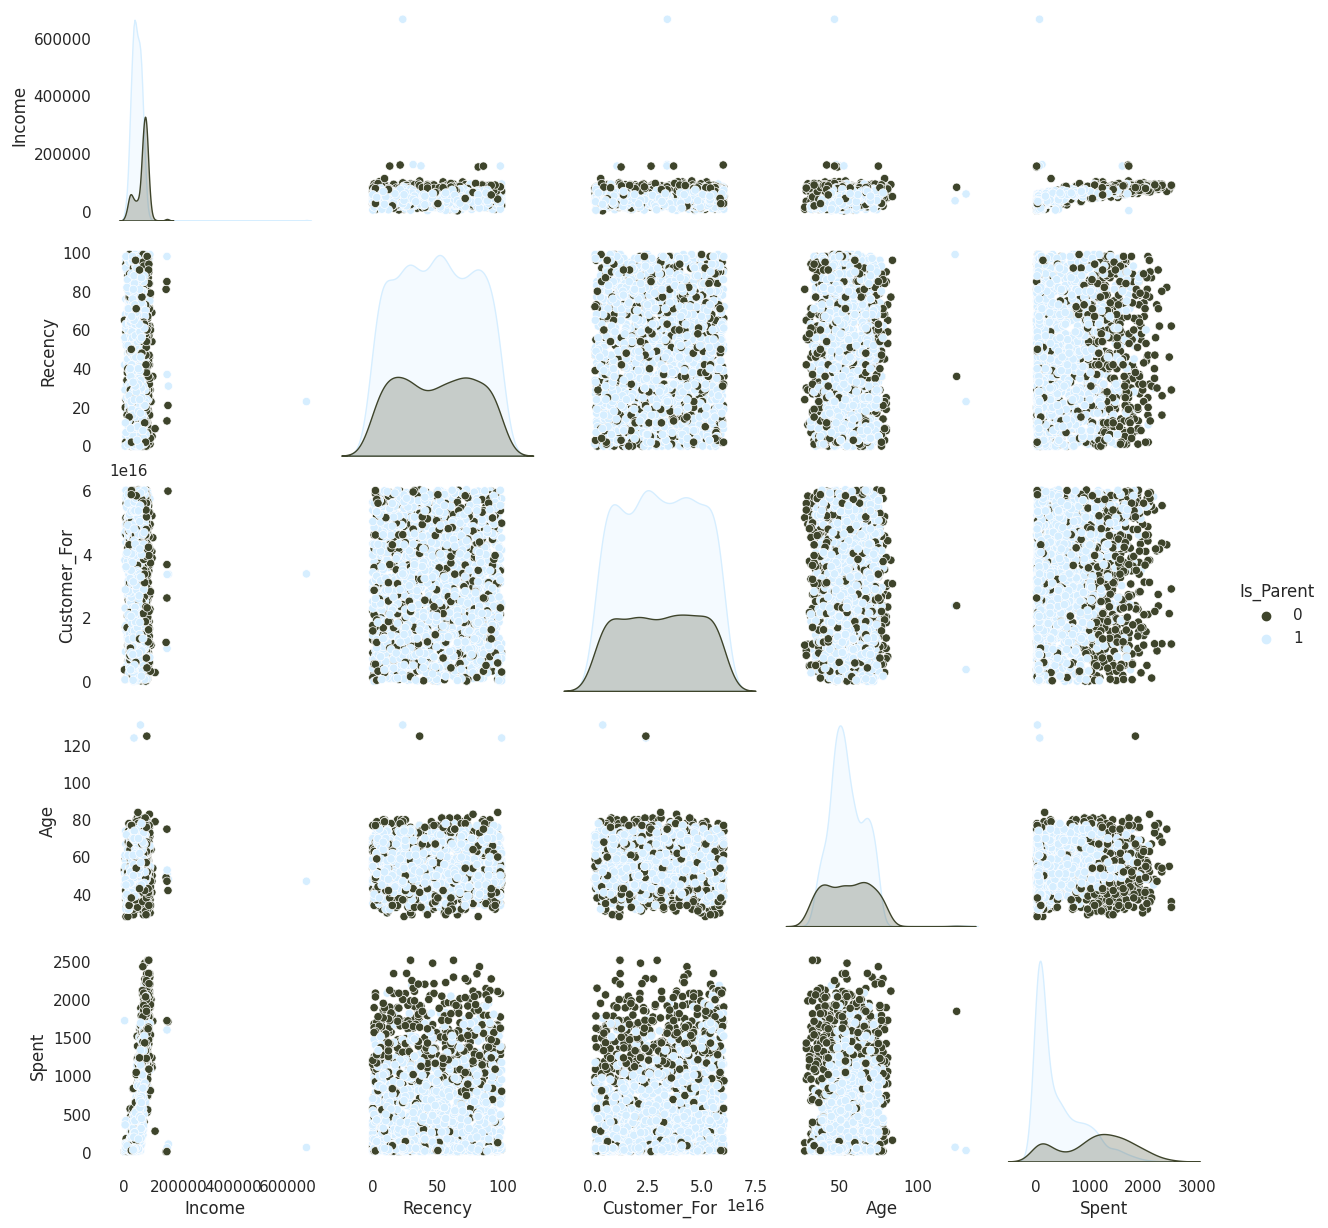

In [13]:
# to plot some selected features

# color preference settings
sns.set(rc= {"axes.facecolor": "#FFFFFF", "figure.facecolor": "#FFFFFF"})
pallet = ["#3E442B", "#6A7062", "#8D909B", "#AAADC4", "#D6EEFF", "#AEC3D3"]
cmap = colors.ListedColormap(["#3E442B", "#6A7062", "#8D909B", "#AAADC4", "#D6EEFF", "#AEC3D3"])

# plotting follows features
To_Plot = ["Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Relative Graph of Some Selected Features: Subdata Subset")

plt.Figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent", palette= (["#3E442B","#D6EEFF"]))

# hue
plt.show()

Clearly, there are several outliers in the Income and Age features.
Now try removing outliers in the data.

In [14]:
# remove outliers by setting limits on Age and Income.

data = data[(data["Age"] < 90)]
data = data[(data["Income"] < 600000)]
print("Number of data-points after removing outliers is:", len(data))

Number of data-points after removing outliers is: 2212


Next, look at the correlation between the features.
(Excluding categorical attributes at this point)

<Axes: >

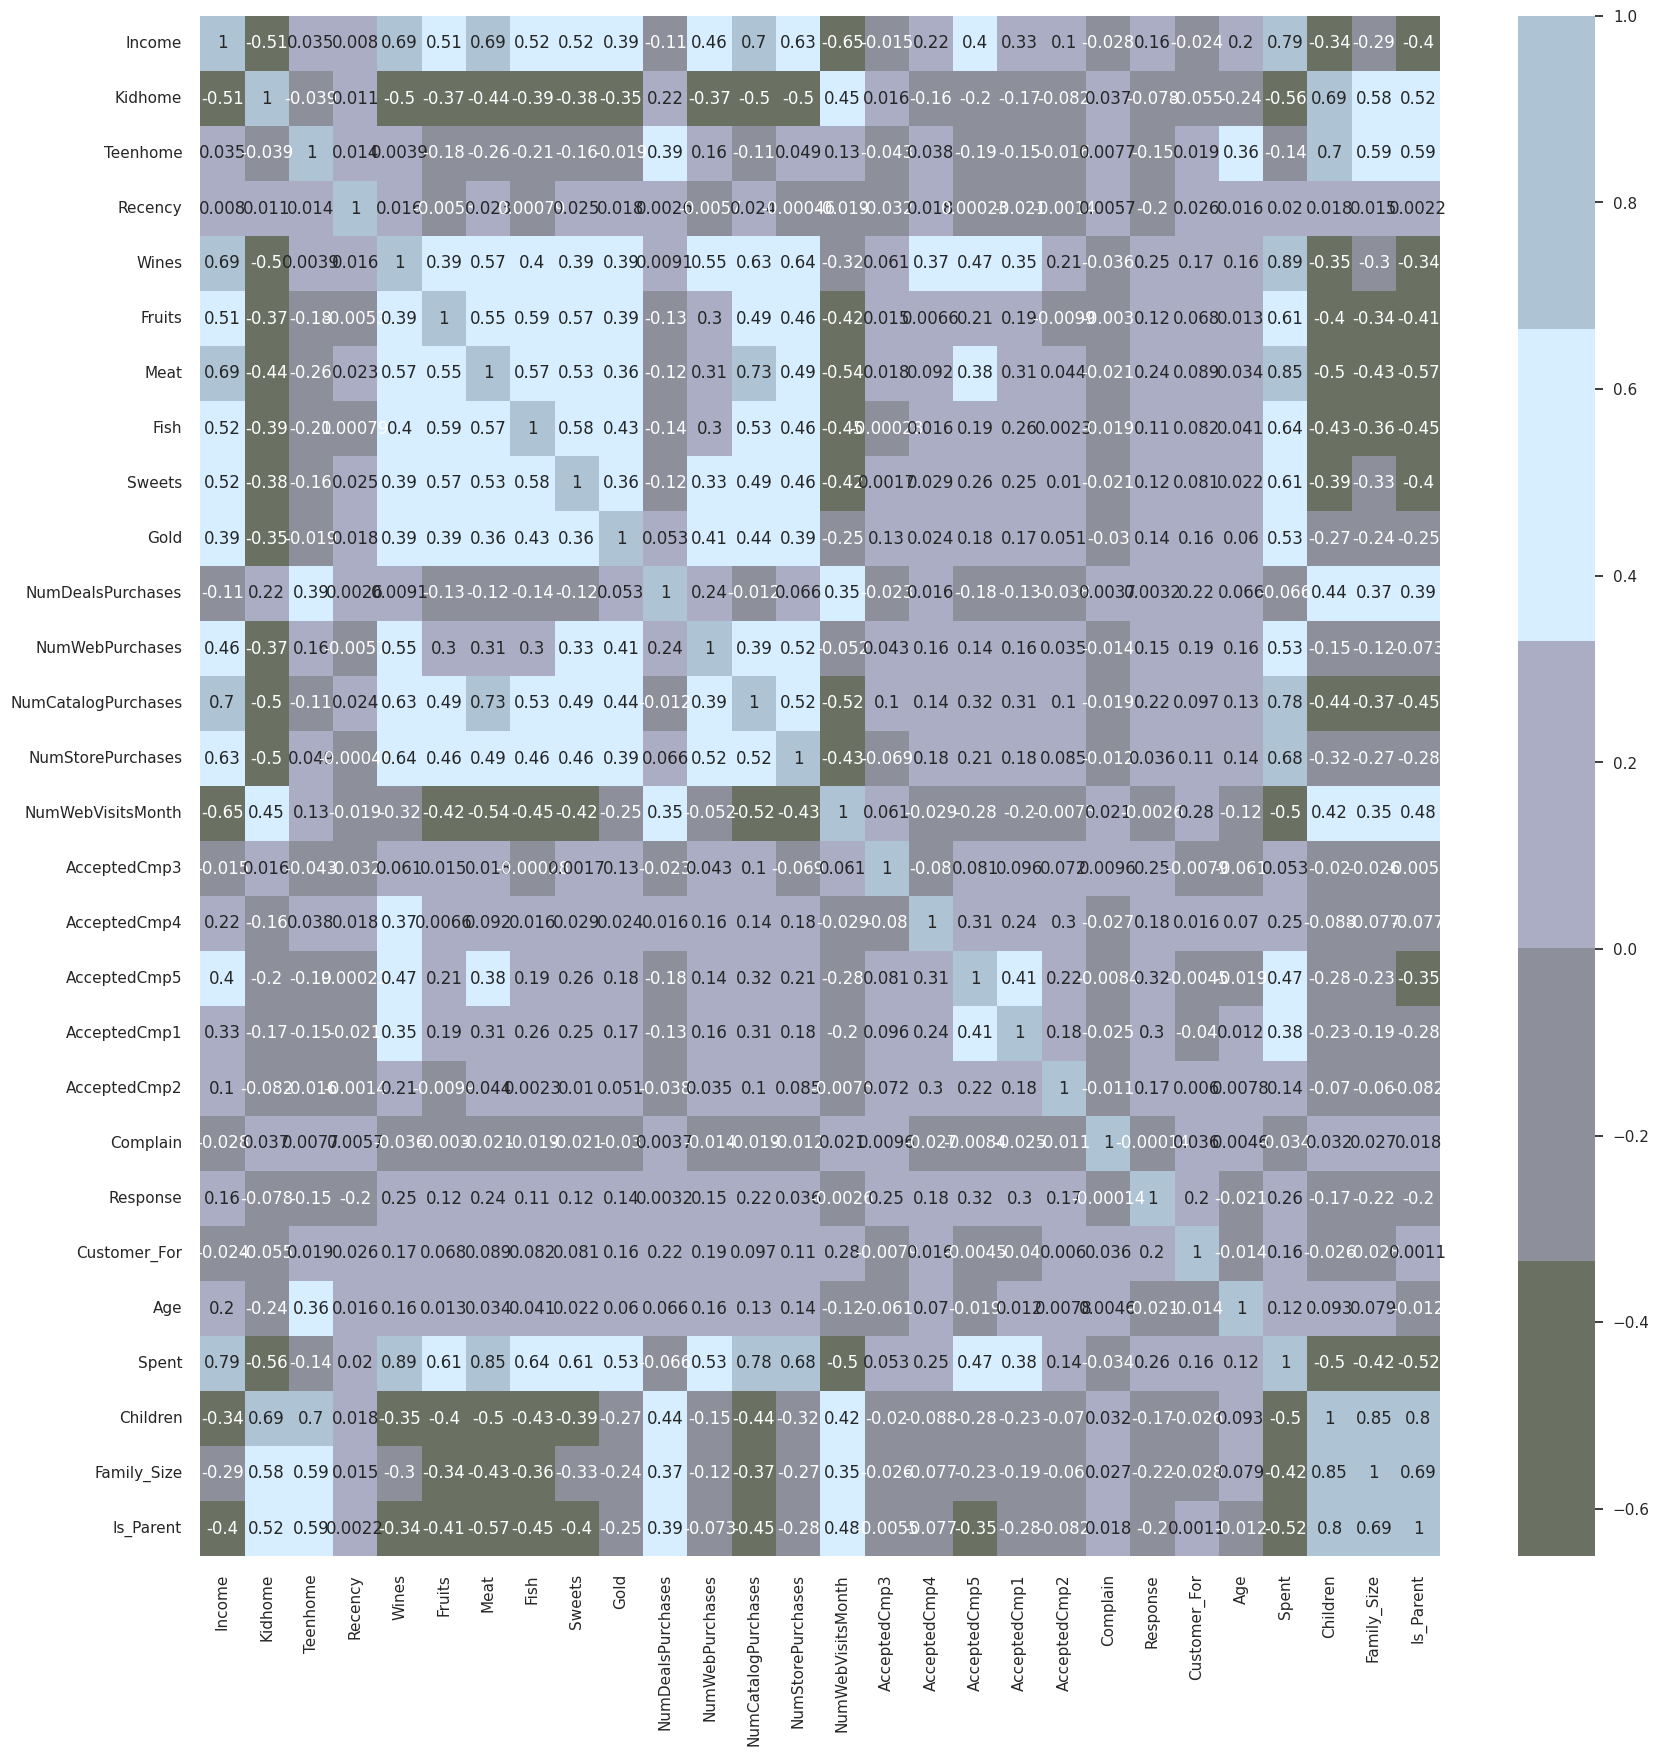

In [15]:
# correlation matrix

num_data = data.drop(columns= ["Education", "Living_With"])
corrmat = num_data.corr()
plt.figure(figsize= (20, 20))  
sns.heatmap(corrmat, annot= True, cmap= cmap, center= 0)

It can be seen that the data has been sufficiently cleaned and new features have been included. Now try continuing to the next step, namely data preprocessing.

# <div style="background-color: #153B50; font-family: Trebuchet MS; color: #FFFFFF; padding: 12px; border-radius: 10px 10px;">Data Preprocessing</div>

In this section, perform preprocessing on the data for the process towards clustering.

**The following steps were implemented to process the data:**

* Label encoding on categorical features
* Feature scaling using standard scaler
* Create DataFrame attributes for dimensionality reduction

In [16]:
# get a list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in Dataset:", object_cols)

Categorical variables in Dataset: ['Education', 'Living_With']


In [17]:
# label encoding for object dtypes
encoder = LabelEncoder()
for i in object_cols:
    data[i] = data[[i]].apply(encoder.fit_transform)

print("All features have become numeric")

All features have become numeric


In [18]:
temp = data.copy()
# create a subset of the DataFrame by removing features related to accepted offers and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']
temp = temp.drop(cols_del, axis=1)

# scaling
scaler = StandardScaler()
scaler.fit(temp)
scaled_temp = pd.DataFrame(scaler.transform(temp), columns= temp.columns)
print("All features have now been scaled")

All features have now been scaled


In [19]:
# Scaled data will be used to reduce dimensionality
print("DataFrame used to create the model:")
scaled_temp.head()

DataFrame used to create the model:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


# <div style="background-color: #153B50; font-family: Trebuchet MS; color: #FFFFFF; padding: 12px; border-radius: 10px 10px;">Dimensionality Reduction</div>

There are numerous things to consider while determining the ultimate classification for this problem. These factors are essentially traits or features. Working with a large number of characteristics becomes increasingly difficult. Many of these qualities are connected and so redundant. As a result, the selected features will undergo dimensionality reduction before being passed to the classifier. 
*Dimensionality reduction is the process of lowering the number of random variables examined to get a set of main variables.*

**Principal Component Analysis (PCA)** is a technique for lowering the dimensionality of datasets like those used in this notebook, improving interpretability while minimizing information loss.


**Steps in this section:**
* Dimensionality reduction with PCA
* reduced DataFrame plotting

**Dimensionality reduction with PCA**

For this project, a dimension reduction of 3 was applied.

In [20]:
# PCA initialization for dimension reduction to 3 features
pca = PCA(n_components= 3)
pca.fit(scaled_temp)

PCA_temp = pd.DataFrame(pca.transform(scaled_temp), columns=(["col1", "col2", "col3"]))
PCA_temp.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,-3.854662e-17,2.878602,-5.978123,-2.539470,-0.781595,2.386380,7.452915
col2,2212.0,-2.569775e-17,1.709469,-4.194757,-1.323932,-0.173716,1.234923,6.168185
col3,2212.0,3.894815e-17,1.231685,-3.625184,-0.853556,-0.051292,0.863841,6.746845


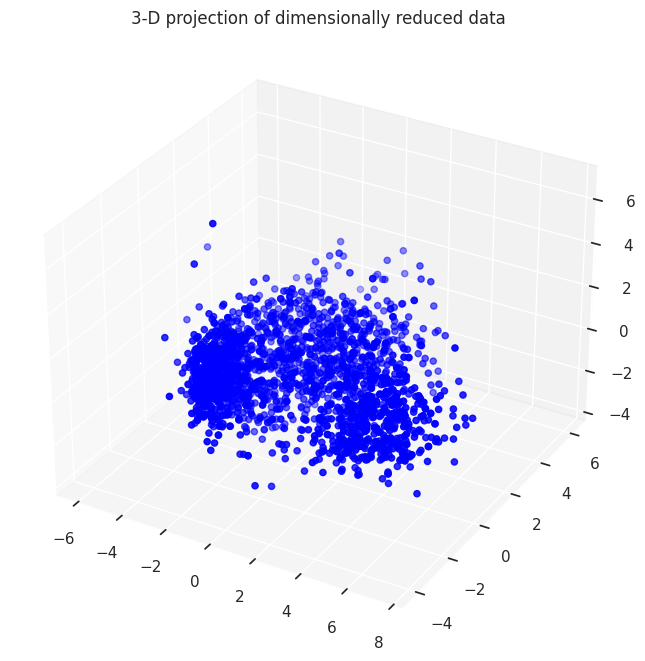

In [22]:
# 3-D projection of dimensionally reduced data
x = PCA_temp["col1"]
y = PCA_temp["col2"]
z = PCA_temp["col3"]

# plot
fig = plt.figure(figsize= (10, 8))
ax = fig.add_subplot(111, projection= "3d")
ax.scatter(x, y, z, c= "blue", marker= "o")
ax.set_title("3-D projection of dimensionally reduced data")
plt.show()

# <div style="background-color: #153B50; font-family: Trebuchet MS; color: #FFFFFF; padding: 12px; border-radius: 10px 10px;">Clustering</div>

Now that the attributes have been reduced to 3 dimensions, try clustering via Agglomerative clustering. Agglomerative clustering is a hierarchical grouping method. This involves merging examples until the desired number of clusters is reached.

**Steps involved in Clustering**
* Elbow Method to determine the number of clusters to be formed
* Grouping via Agglomerative Clustering
* Check the clusters formed through scatter plots

Elbow Method to determine the number of clusters to be formed:


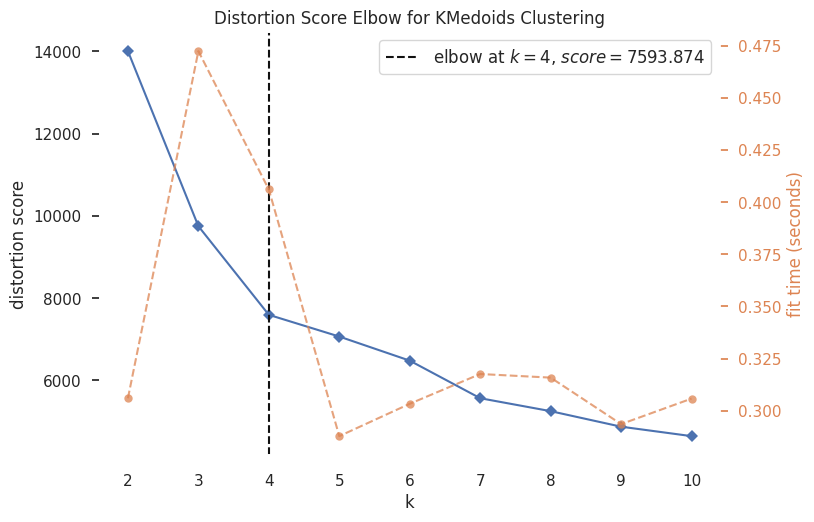

<Axes: title={'center': 'Distortion Score Elbow for KMedoids Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
# Elbow Method check to find the number of clusters to be formed

print("Elbow Method to determine the number of clusters to be formed:")
Elbow_M = KElbowVisualizer(KMedoids(), k= 10)
Elbow_M.fit(PCA_temp)
Elbow_M.show()

The results above indicate that 4 clusters would be the optimal number of clusters for this data. <br />
Next, adjust the Agglomerative Clustering Model to get the final clusters.

In [24]:
# initialize the Agglomerative Clustering model
AC = AgglomerativeClustering(n_clusters= 4)

# fit model and predict cluster
yhat_AC = AC.fit_predict(PCA_temp)
PCA_temp["Clusters"] = yhat_AC

# add the Clusters feature to the original DataFrame
data["Clusters"] = yhat_AC

To examine the clusters that form, look at the 3-D distribution of the clusters.

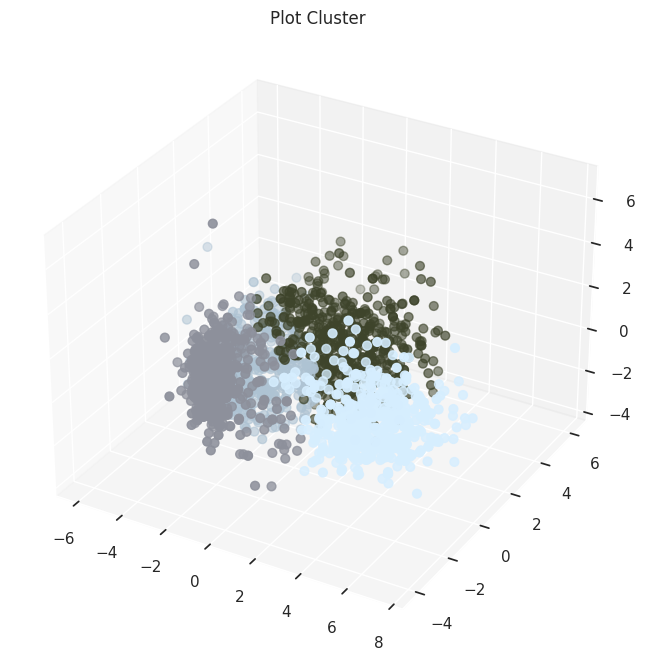

In [25]:
# plot clusters
fig = plt.figure(figsize= (10, 8))
ax = plt.subplot(111, projection= "3d", label= "bla")
ax.scatter(x, y, z, s= 40, c= PCA_temp["Clusters"], marker= 'o', cmap= cmap )
ax.set_title("Plot Cluster")
plt.show()

# <div style="background-color: #153B50; font-family: Trebuchet MS; color: #FFFFFF; padding: 12px; border-radius: 10px 10px;">Evaluating Models</div>

Because this model is unsupervised clustering. There are no features available to evaluate or rate this model. The purpose of this section is to study the patterns in the clusters that are formed and determine the nature of these cluster patterns.

For this reason, let's look at the data in the context of clusters through exploratory data analysis and draw conclusions.

**First, let's look at the group distribution of clustering**

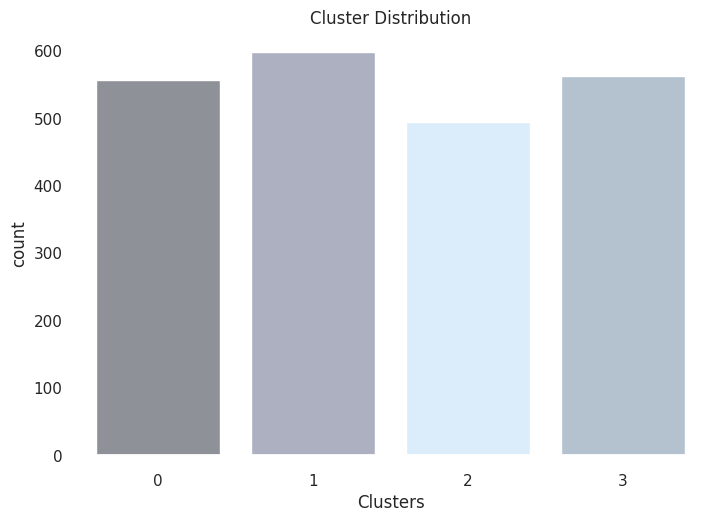

In [26]:
# plot countplot of clusters

pal = ["#8D909B", "#AAADC4", "#D6EEFF", "#AEC3D3"]
pl = sns.countplot(x= data["Clusters"], palette= pal)
pl.set_title("Cluster Distribution")
plt.show()

The clusters appear to be quite distributed

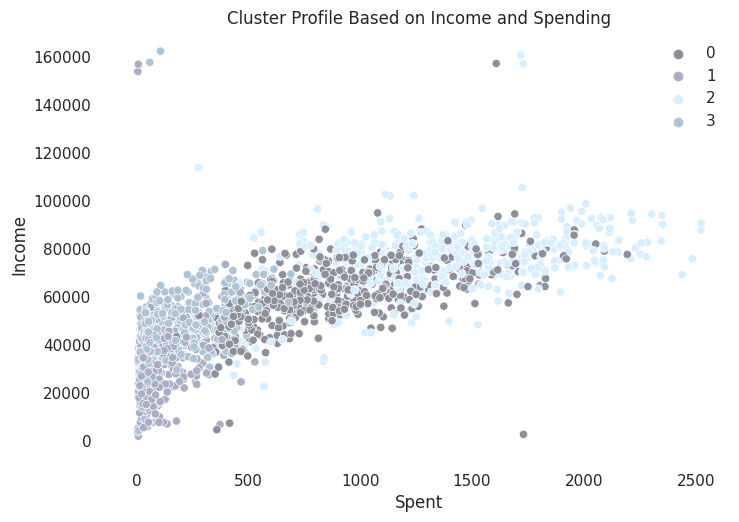

In [27]:
pl = sns.scatterplot(data= data,x= data["Spent"], y= data["Income"], hue= data["Clusters"], palette= pal)
pl.set_title("Cluster Profile Based on Income and Spending")
plt.legend()
plt.show()

**Income vs Spend graph shows a cluster pattern**

* group 0: High spend & average Income
* group 1: High spend & high income
* group 2: Low spend & low income
* group 3: High spend & low income

Next, let's look at the detailed distribution of clusters based on the various products in the data. Namely: Wine, Fruit, Meat, Fish, Candy, and Gold

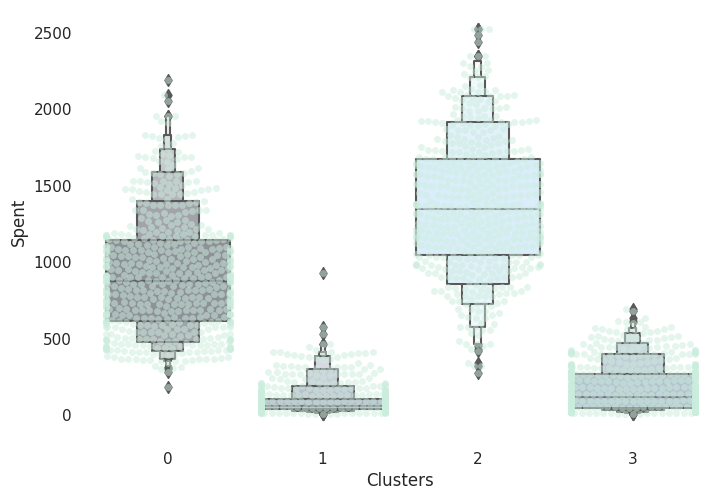

In [28]:
plt.figure()
pl = sns.swarmplot(x= data["Clusters"], y= data["Spent"], color= "#CBEDDD", alpha=0.5)
pl = sns.boxenplot(x= data["Clusters"], y= data["Spent"], palette= pal)
plt.show()

From the above plot, it is clearly visible that cluster 1 is the largest set of customers followed closely by cluster 0.
Explore what each cluster spends on targeted marketing strategies.

Let's explore how promotions have performed in the past.

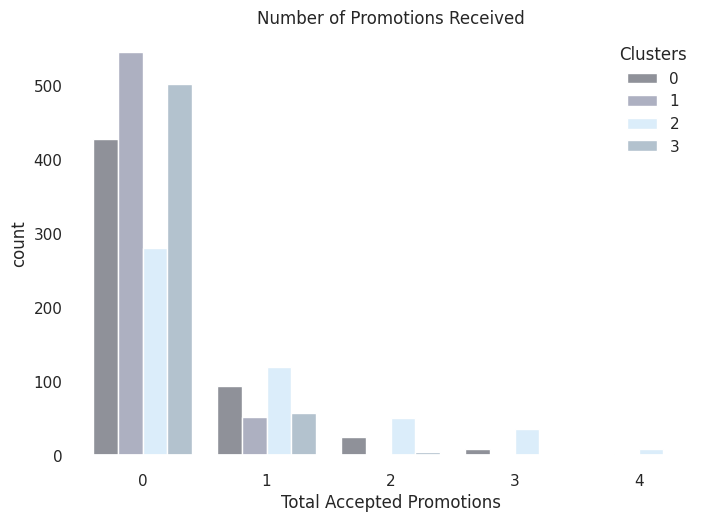

In [29]:
# create a feature to total the promotions received
data["Total_Promos"] = data["AcceptedCmp1"] + data["AcceptedCmp2"] + data["AcceptedCmp3"] + data["AcceptedCmp4"] + data["AcceptedCmp5"]

# plot the total number of promotions received
plt.figure()
pl = sns.countplot(x= data["Total_Promos"], hue= data["Clusters"], palette= pal)
pl.set_title("Number of Promotions Received")
pl.set_xlabel("Total Accepted Promotions")
plt.show()

There has been no overwhelming response to the promotions made so far. Very few participants overall. Apart from that, no one took part in all 5 promotions. Perhaps better targeted and well-planned promotions are needed to increase sales.

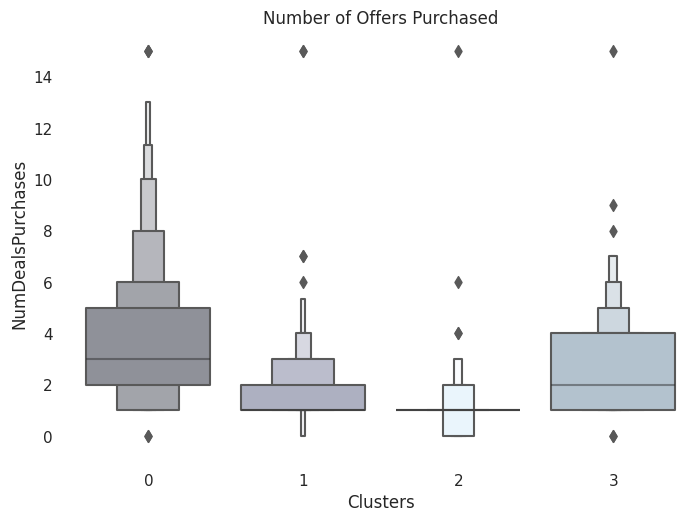

In [30]:
# plot the number of offers purchased
plt.figure()
pl = sns.boxenplot(y= data["NumDealsPurchases"], x= data["Clusters"], palette= pal)
pl.set_title("Number of Offers Purchased")
plt.show()

In contrast to campaigns, the offers offered are successful. It has the best results with cluster 0 and cluster 3.
However, customers in cluster 1 are not very interested in the offer.
Nothing seems to attract cluster 2 in a big way.

<Figure size 800x550 with 0 Axes>

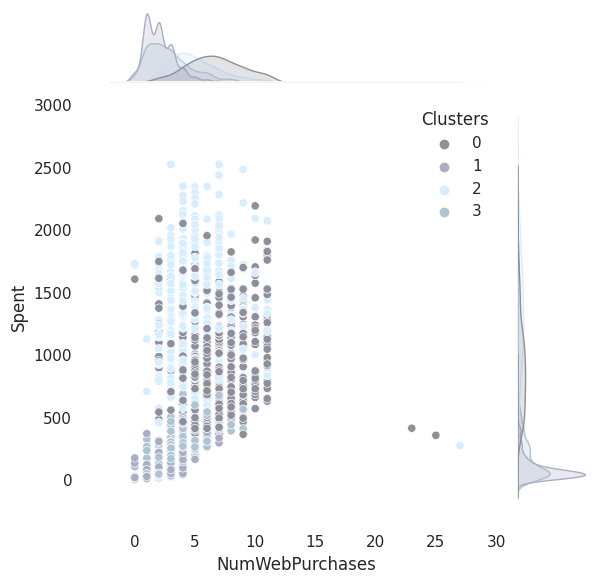

<Figure size 800x550 with 0 Axes>

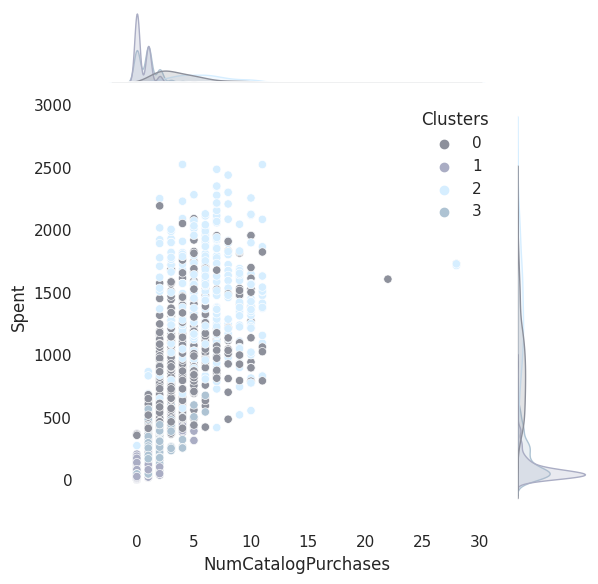

<Figure size 800x550 with 0 Axes>

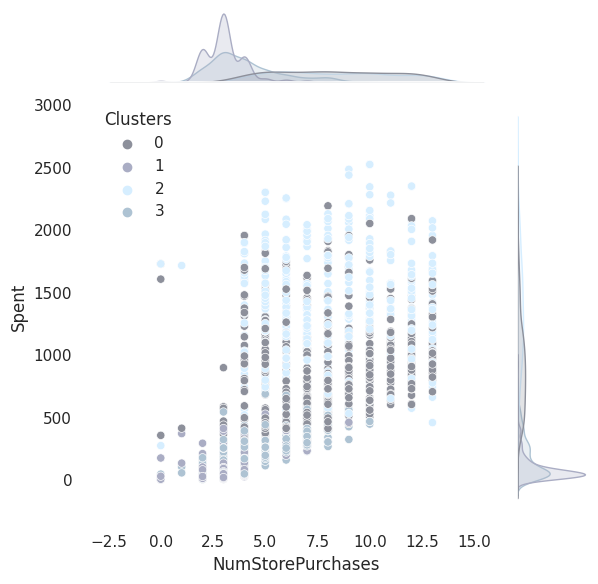

<Figure size 800x550 with 0 Axes>

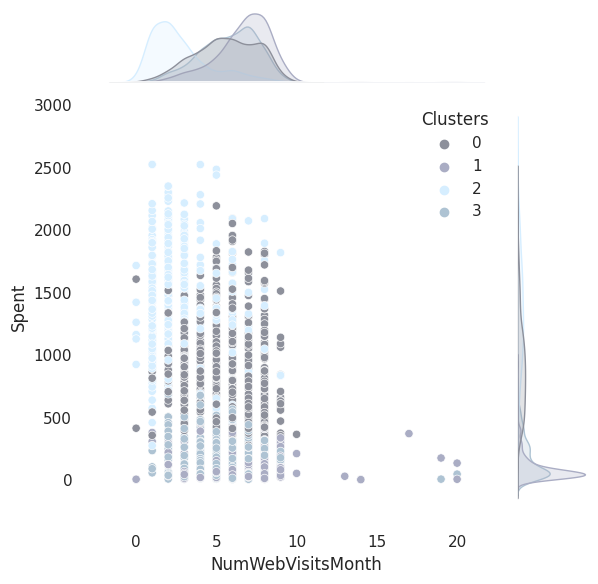

In [31]:
# for more details of purchasing style
Places = ["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases", "NumWebVisitsMonth"] 

for i in Places:
    plt.figure()
    sns.jointplot(x= data[i], y= data["Spent"], hue= data["Clusters"], palette= pal)
    plt.show()

# <div style="background-color: #153B50; font-family: Trebuchet MS; color: #FFFFFF; padding: 12px; border-radius: 10px 10px;">Profiling</div>

After establishing groups and analyzing their purchase habits. Let us examine who is in the clusters. Create a profile of the clusters formed and determine who are the primary customers and who require further attention from the retail store marketing staff.

To do so, plot many elements that represent a customer's personal traits within the context of the cluster they are in. We shall draw a conclusion based on the results.

<Figure size 800x550 with 0 Axes>

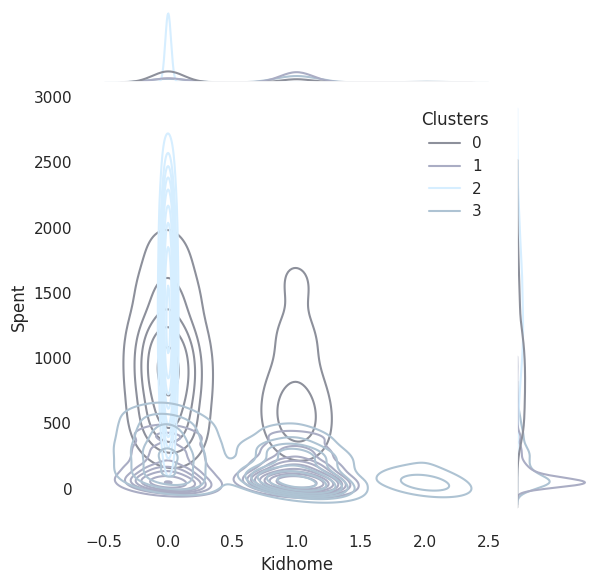

<Figure size 800x550 with 0 Axes>

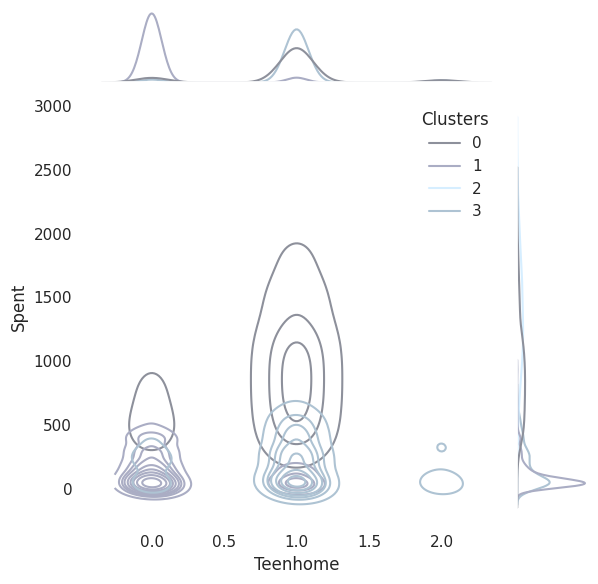

<Figure size 800x550 with 0 Axes>

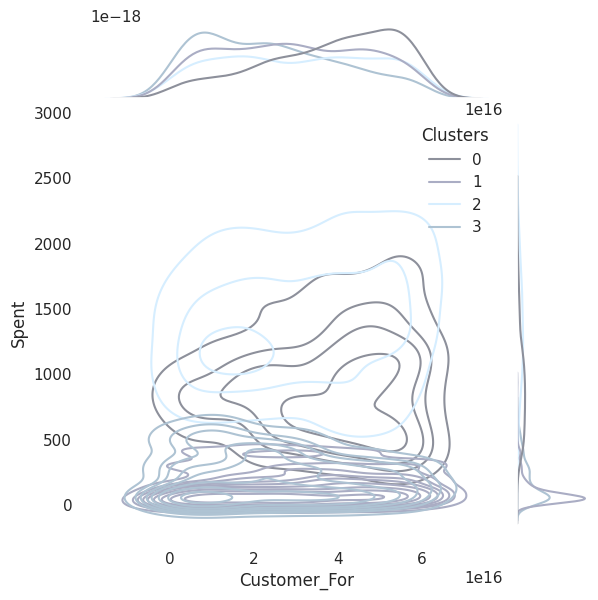

<Figure size 800x550 with 0 Axes>

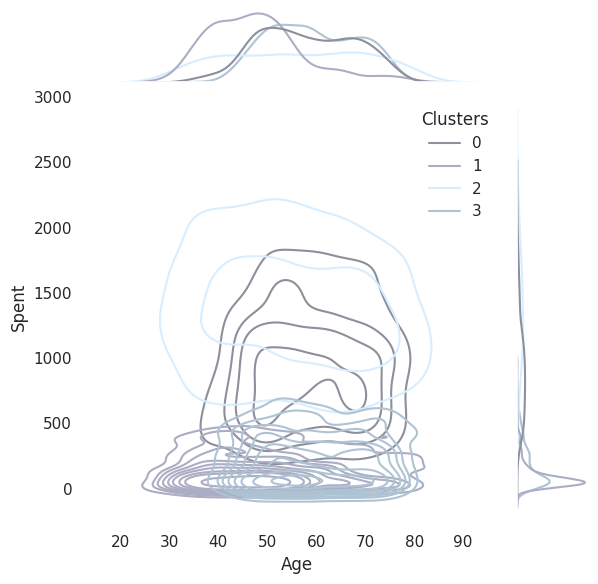

<Figure size 800x550 with 0 Axes>

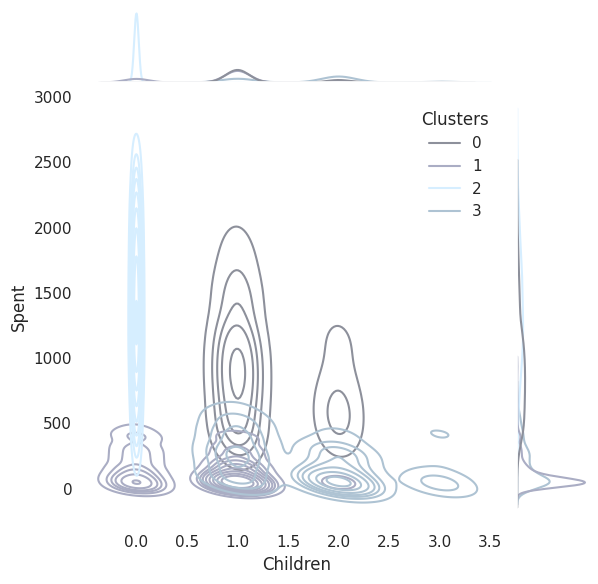

<Figure size 800x550 with 0 Axes>

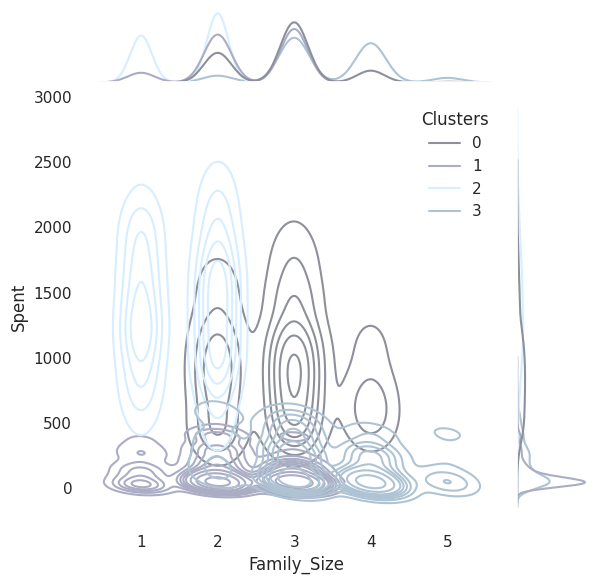

<Figure size 800x550 with 0 Axes>

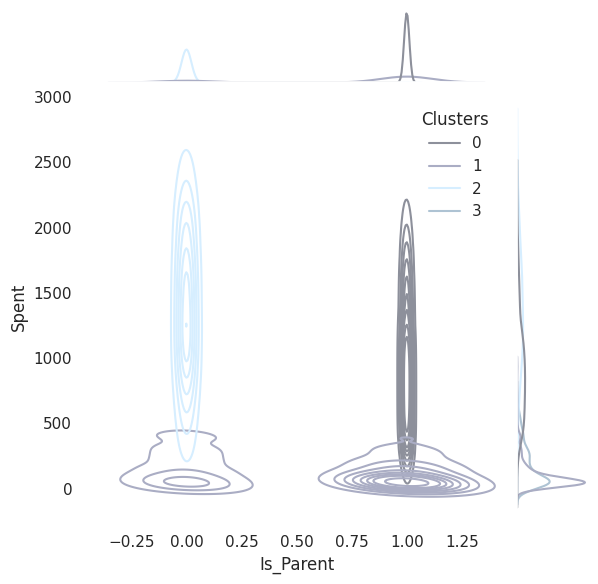

<Figure size 800x550 with 0 Axes>

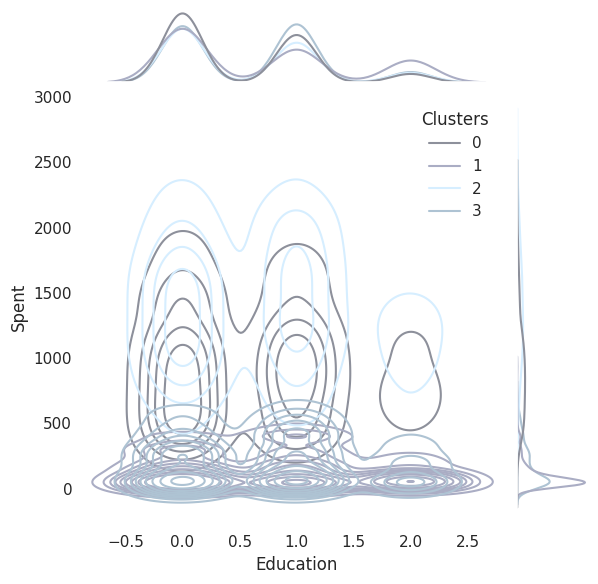

<Figure size 800x550 with 0 Axes>

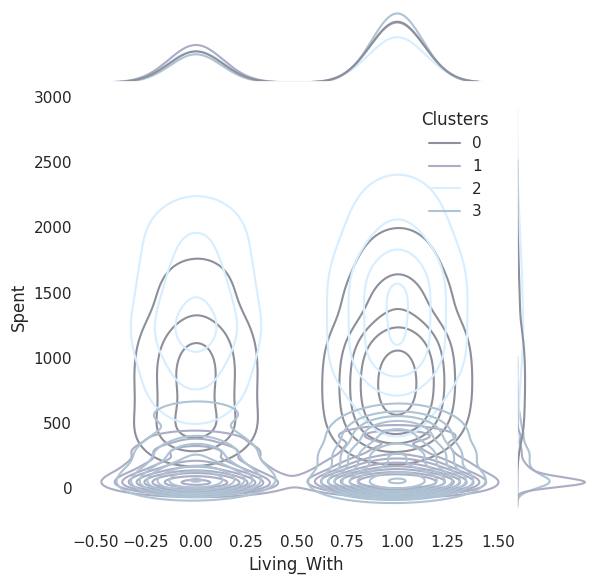

In [32]:
Personal = ["Kidhome", "Teenhome", "Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education", "Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x= data[i], y= data["Spent"], hue= data["Clusters"], kind= "kde", palette= pal)
    plt.show()

**Points to note:**

The following information can be inferred about customers in various clusters.

**Cluster 0:**
* They are definitely parents.
* Maximum of 4 family members and minimum of 2.
* Single Parent is a subset of this group.
* Most have teenagers at home.
* Relatively older.

**Cluster 1:**

*They are definitely not parents.
* There is a maximum of only 2 members in the family.
* Most are couples rather than single individuals.
* Consists of all age ranges.
* Group with high income.

**Cluster 2:**

* Most of them are parents.
* There is a maximum of 3 members in the family.
* Most have one child (and not a teenager, usually).
* Relatively younger.

**Cluster 3:**

* They must be parents.
* There is a maximum of 5 members in the family and a minimum of 2.
* Most of them have teenagers at home.
* Relatively older.
* And groups with lower income.

# <div style="background-color: #153B50; font-family: Trebuchet MS; color: #FFFFFF; padding: 12px; border-radius: 10px 10px;">Conclusion</div>

In this project, unsupervised clustering was created. Using dimensionality reduction followed by agglomerative clustering. Obtained 4 clusters and further used them in creating customer profiles in the clusters based on their family structure and income/expenses. This can be used in planning better marketing strategies.